## Test Década
En este notebook, analizaremos si es posible mejorar los modelos clasificando las canciones por décadas.


In [6]:
import pandas as pd

In [8]:
df_final=pd.read_csv('df_final.csv')

In [9]:
df_final['Stream'].describe()

count    1.686600e+04
mean     1.362465e+08
std      2.433885e+08
min      6.574000e+03
25%      1.748466e+07
50%      4.993142e+07
75%      1.391041e+08
max      3.386520e+09
Name: Stream, dtype: float64

Vamos a ver cuantas canciones hay por década

In [11]:
# Agrupar por 'decada' y contar el número de tracks
df_decadas_count = df_final.groupby('Decada', as_index=False).size()

# Renombrar las columnas para mayor claridad
df_decadas_count.columns = ['Decada', 'Num_Tracks']

# Ordenar por número de tracks en orden descendente
df_decadas_count = df_decadas_count.sort_values(by='Num_Tracks', ascending=False)

# Reiniciar el índice para un formato limpio
df_decadas_count.reset_index(drop=True, inplace=True)

# Mostrar el DataFrame
print(df_decadas_count)

   Decada  Num_Tracks
0    2020        5665
1    2010        5463
2    2000        2477
3    1990        1494
4    1980         863
5    1970         597
6    1960         253
7    1950          44
8    1940          10


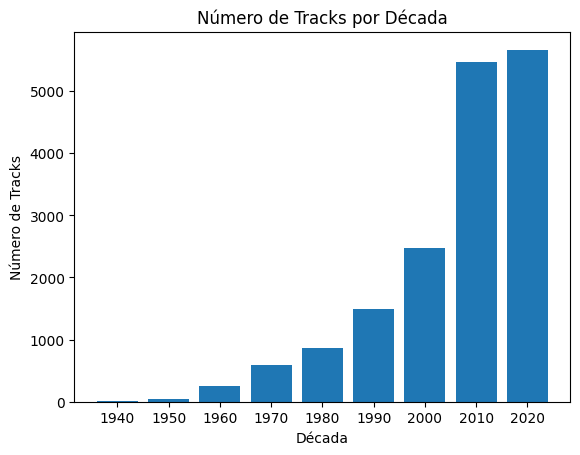

In [14]:
# Contar el número de tracks por década
tracks_por_decada = df_final['Decada'].value_counts().sort_index()

# Crear el histograma
plt.bar(tracks_por_decada.index, tracks_por_decada.values, width=8)  # width ajusta el ancho de las barras
plt.xlabel('Década')
plt.ylabel('Número de Tracks')
plt.title('Número de Tracks por Década')
plt.xticks(tracks_por_decada.index)  # Mostrar las décadas en el eje X
plt.show()

El análisis se realizará a partir de la década de los 70, ya que a partir de este periodo contamos con un número suficiente de datos para entrenar los algoritmos.

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier

# Lista de Decadas a evaluar
decadas = [1970, 1980, 1990, 2000, 2010, 2020]

# Diccionario para almacenar resultados
test = {}

for decada in decadas:
    # Filtrar por Decada y hacer una copia para evitar errores
    df_decada = df_final[df_final['Decada'] == decada].copy()

    # Calcular el tercer cuartil (Q3)
    q3 = df_decada['Stream'].quantile(0.75)

    # Definir las categorías
    bins = [0, q3, df_decada['Stream'].max()]
    labels = [0, 1]

    df_decada['Categoria'] = pd.cut(df_decada['Stream'], bins=bins, labels=labels, include_lowest=True)

    # Verificar si hay suficientes muestras en la categoría 1
    count_cat1 = df_decada['Categoria'].value_counts().get(1, 0)

    if count_cat1 == 0:
        print(f"⚠️ Decada {decada}: No hay suficientes muestras en la categoría 1, saltando...")
        continue

    # Filtrar por categorías
    categoria_0 = df_decada[df_decada['Categoria'] == 0]
    categoria_1 = df_decada[df_decada['Categoria'] == 1]

    # Muestrear la categoría 0 con el mismo número de elementos que la categoría 1
    categoria_0_sample = categoria_0.sample(n=min(count_cat1, len(categoria_0)), random_state=42)

    # Concatenar para obtener un dataset balanceado
    df_balanceado = pd.concat([categoria_0_sample, categoria_1]).sample(frac=1, random_state=42).reset_index(drop=True)

    # Definir variables predictoras y objetivo
    X = df_balanceado[['Acousticness', 'Danceability', 'Duration_min', 'Energy',
                       'Instrumentalness', 'Key', 'Liveness', 'Loudness',
                       'Speechiness', 'Tempo', 'Valence']]
    y = df_balanceado['Categoria']

    # Dividir en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Evaluación con LazyClassifier
    lazy_clf = LazyClassifier(verbose=0, ignore_warnings=False, custom_metric=None)
    models, predictions = lazy_clf.fit(X_train, X_test, y_train, y_test)

    # Guardar resultados en el diccionario
    test[decada] = models

print("✅ Evaluación completada para todos los Decadas.")

 28%|██▊       | 9/32 [00:00<00:00, 28.97it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X).
FixedThresholdClassifier model failed to execute
FixedThresholdClassifier.__init__() missing 1 required positional argument: 'estimator'


 81%|████████▏ | 26/32 [00:00<00:00, 36.07it/s]

SelfTrainingClassifier model failed to execute
You must pass an estimator to SelfTrainingClassifier. Use `estimator`.
StackingClassifier model failed to execute
StackingClassifier.__init__() missing 1 required positional argument: 'estimators'
TunedThresholdClassifierCV model failed to execute
TunedThresholdClassifierCV.__init__() missing 1 required positional argument: 'estimator'


100%|██████████| 32/32 [00:01<00:00, 24.46it/s]


XGBClassifier model failed to execute
'super' object has no attribute '__sklearn_tags__'
[LightGBM] [Info] Number of positive: 118, number of negative: 120
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 781
[LightGBM] [Info] Number of data points in the train set: 238, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495798 -> initscore=-0.016807
[LightGBM] [Info] Start training from score -0.016807
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

 28%|██▊       | 9/32 [00:00<00:00, 29.15it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X).
FixedThresholdClassifier model failed to execute
FixedThresholdClassifier.__init__() missing 1 required positional argument: 'estimator'


 97%|█████████▋| 31/32 [00:01<00:00, 23.59it/s]

SelfTrainingClassifier model failed to execute
You must pass an estimator to SelfTrainingClassifier. Use `estimator`.
StackingClassifier model failed to execute
StackingClassifier.__init__() missing 1 required positional argument: 'estimators'
TunedThresholdClassifierCV model failed to execute
TunedThresholdClassifierCV.__init__() missing 1 required positional argument: 'estimator'
XGBClassifier model failed to execute
'super' object has no attribute '__sklearn_tags__'
[LightGBM] [Info] Number of positive: 180, number of negative: 165
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1107


100%|██████████| 32/32 [00:01<00:00, 26.21it/s]


[LightGBM] [Info] Number of data points in the train set: 345, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.521739 -> initscore=0.087011
[LightGBM] [Info] Start training from score 0.087011
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

 28%|██▊       | 9/32 [00:00<00:00, 23.45it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X).
FixedThresholdClassifier model failed to execute
FixedThresholdClassifier.__init__() missing 1 required positional argument: 'estimator'


 72%|███████▏  | 23/32 [00:00<00:00, 26.45it/s]

SelfTrainingClassifier model failed to execute
You must pass an estimator to SelfTrainingClassifier. Use `estimator`.
StackingClassifier model failed to execute
StackingClassifier.__init__() missing 1 required positional argument: 'estimators'
TunedThresholdClassifierCV model failed to execute
TunedThresholdClassifierCV.__init__() missing 1 required positional argument: 'estimator'


100%|██████████| 32/32 [00:01<00:00, 25.61it/s]


XGBClassifier model failed to execute
'super' object has no attribute '__sklearn_tags__'
[LightGBM] [Info] Number of positive: 304, number of negative: 294
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1994
[LightGBM] [Info] Number of data points in the train set: 598, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508361 -> initscore=0.033448
[LightGBM] [Info] Start training from score 0.033448
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

 28%|██▊       | 9/32 [00:00<00:01, 21.24it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X).
FixedThresholdClassifier model failed to execute
FixedThresholdClassifier.__init__() missing 1 required positional argument: 'estimator'


 72%|███████▏  | 23/32 [00:01<00:00, 19.44it/s]

SelfTrainingClassifier model failed to execute
You must pass an estimator to SelfTrainingClassifier. Use `estimator`.
StackingClassifier model failed to execute
StackingClassifier.__init__() missing 1 required positional argument: 'estimators'
TunedThresholdClassifierCV model failed to execute
TunedThresholdClassifierCV.__init__() missing 1 required positional argument: 'estimator'


100%|██████████| 32/32 [00:01<00:00, 18.26it/s]


XGBClassifier model failed to execute
'super' object has no attribute '__sklearn_tags__'
[LightGBM] [Info] Number of positive: 493, number of negative: 497
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2561
[LightGBM] [Info] Number of data points in the train set: 990, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497980 -> initscore=-0.008081
[LightGBM] [Info] Start training from score -0.008081


 19%|█▉        | 6/32 [00:00<00:01, 16.52it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X).


 28%|██▊       | 9/32 [00:00<00:01, 12.07it/s]

FixedThresholdClassifier model failed to execute
FixedThresholdClassifier.__init__() missing 1 required positional argument: 'estimator'


 84%|████████▍ | 27/32 [00:02<00:00,  9.32it/s]

SelfTrainingClassifier model failed to execute
You must pass an estimator to SelfTrainingClassifier. Use `estimator`.
StackingClassifier model failed to execute
StackingClassifier.__init__() missing 1 required positional argument: 'estimators'
TunedThresholdClassifierCV model failed to execute
TunedThresholdClassifierCV.__init__() missing 1 required positional argument: 'estimator'


100%|██████████| 32/32 [00:03<00:00,  9.60it/s]


XGBClassifier model failed to execute
'super' object has no attribute '__sklearn_tags__'
[LightGBM] [Info] Number of positive: 1105, number of negative: 1080
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2563
[LightGBM] [Info] Number of data points in the train set: 2185, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505721 -> initscore=0.022884
[LightGBM] [Info] Start training from score 0.022884


 19%|█▉        | 6/32 [00:00<00:01, 13.79it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X).


 28%|██▊       | 9/32 [00:00<00:02, 10.80it/s]

FixedThresholdClassifier model failed to execute
FixedThresholdClassifier.__init__() missing 1 required positional argument: 'estimator'


 84%|████████▍ | 27/32 [00:03<00:00,  8.60it/s]

SelfTrainingClassifier model failed to execute
You must pass an estimator to SelfTrainingClassifier. Use `estimator`.
StackingClassifier model failed to execute
StackingClassifier.__init__() missing 1 required positional argument: 'estimators'
TunedThresholdClassifierCV model failed to execute
TunedThresholdClassifierCV.__init__() missing 1 required positional argument: 'estimator'


100%|██████████| 32/32 [00:03<00:00,  8.41it/s]

XGBClassifier model failed to execute
'super' object has no attribute '__sklearn_tags__'
[LightGBM] [Info] Number of positive: 1134, number of negative: 1131
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2563
[LightGBM] [Info] Number of data points in the train set: 2265, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500662 -> initscore=0.002649
[LightGBM] [Info] Start training from score 0.002649
✅ Evaluación completada para todos los Decadas.


In [32]:
for i in test.keys():
    print(f'Modelos de la década {i}')
    display(test[i])  # Esto imprimirá los resultados de LazyClassifier

Modelos de la década 1970


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
SGDClassifier,0.53,0.54,0.54,0.53,0.02
ExtraTreeClassifier,0.53,0.54,0.54,0.53,0.01
KNeighborsClassifier,0.53,0.53,0.53,0.53,0.04
BaggingClassifier,0.50,0.50,0.50,0.50,0.04
Perceptron,0.50,0.50,0.50,0.50,0.02
DummyClassifier,0.48,0.50,0.50,0.31,0.02
LabelSpreading,0.50,0.50,0.50,0.50,0.04
LabelPropagation,0.50,0.50,0.50,0.50,0.06
NearestCentroid,0.50,0.49,0.49,0.48,0.03


Modelos de la década 1980


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
BernoulliNB,0.60,0.61,0.61,0.60,0.01
SVC,0.57,0.60,0.60,0.57,0.02
Perceptron,0.60,0.60,0.60,0.60,0.02
NearestCentroid,0.57,0.60,0.60,0.57,0.02
ExtraTreesClassifier,0.56,0.58,0.58,0.56,0.11
RandomForestClassifier,0.56,0.57,0.57,0.57,0.15
LinearDiscriminantAnalysis,0.54,0.57,0.57,0.53,0.02
LogisticRegression,0.54,0.57,0.57,0.53,0.03
LinearSVC,0.54,0.57,0.57,0.53,0.03


Modelos de la década 1990


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
CalibratedClassifierCV,0.64,0.65,0.65,0.64,0.04
LinearSVC,0.64,0.65,0.65,0.64,0.02
RidgeClassifier,0.63,0.64,0.64,0.63,0.02
RidgeClassifierCV,0.63,0.64,0.64,0.63,0.02
LinearDiscriminantAnalysis,0.63,0.64,0.64,0.63,0.02
RandomForestClassifier,0.64,0.64,0.64,0.64,0.20
LogisticRegression,0.63,0.64,0.64,0.63,0.02
SGDClassifier,0.62,0.63,0.63,0.61,0.01
BaggingClassifier,0.63,0.62,0.62,0.63,0.06


Modelos de la década 2000


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
BernoulliNB,0.62,0.62,0.62,0.61,0.01
SGDClassifier,0.60,0.60,0.60,0.60,0.02
RandomForestClassifier,0.59,0.59,0.59,0.59,0.29
ExtraTreesClassifier,0.58,0.58,0.58,0.58,0.17
GaussianNB,0.58,0.58,0.58,0.53,0.02
SVC,0.57,0.57,0.57,0.56,0.05
LabelPropagation,0.57,0.57,0.57,0.57,0.08
LabelSpreading,0.57,0.57,0.57,0.57,0.08
NuSVC,0.57,0.57,0.57,0.57,0.07


Modelos de la década 2010


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
ExtraTreesClassifier,0.62,0.62,0.62,0.62,0.28
LGBMClassifier,0.62,0.62,0.62,0.62,0.06
RandomForestClassifier,0.62,0.62,0.62,0.62,0.51
AdaBoostClassifier,0.62,0.62,0.62,0.62,0.21
SVC,0.61,0.62,0.62,0.61,0.14
NuSVC,0.61,0.62,0.62,0.61,0.33
SGDClassifier,0.61,0.61,0.61,0.61,0.01
QuadraticDiscriminantAnalysis,0.60,0.61,0.61,0.57,0.01
BaggingClassifier,0.61,0.61,0.61,0.61,0.15


Modelos de la década 2020


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LogisticRegression,0.60,0.61,0.61,0.60,0.04
LinearSVC,0.60,0.60,0.60,0.60,0.02
RidgeClassifierCV,0.60,0.60,0.60,0.60,0.02
LinearDiscriminantAnalysis,0.59,0.59,0.59,0.59,0.03
RidgeClassifier,0.59,0.59,0.59,0.59,0.01
CalibratedClassifierCV,0.59,0.59,0.59,0.59,0.04
LGBMClassifier,0.59,0.59,0.59,0.59,0.07
SVC,0.57,0.58,0.58,0.57,0.16
AdaBoostClassifier,0.56,0.56,0.56,0.56,0.20


El comportamiento es muy similar a lo obtenido con el df total. vamos a entrenar el de la década de 2010 para ver si obtenemos u mejor rendimiento

In [31]:
decada=2010
df_decada = df_final[df_final['Decada'] == decada].copy()

    # Calcular el tercer cuartil (Q3)
q3 = df_decada['Stream'].quantile(0.75)

    # Definir las categorías
bins = [0, q3, df_decada['Stream'].max()]
labels = [0, 1]

df_decada['Categoria'] = pd.cut(df_decada['Stream'], bins=bins, labels=labels, include_lowest=True)

    # Verificar si hay suficientes muestras en la categoría 1
count_cat1 = df_decada['Categoria'].value_counts().get(1, 0)



# Filtrar por categorías
categoria_0 = df_decada[df_decada['Categoria'] == 0]
categoria_1 = df_decada[df_decada['Categoria'] == 1]

    # Muestrear la categoría 0 con el mismo número de elementos que la categoría 1
categoria_0_sample = categoria_0.sample(n=min(count_cat1, len(categoria_0)), random_state=42)

    # Concatenar para obtener un dataset balanceado
    # df_balanceado = pd.concat([categoria_0_sample, categoria_1]).sample(frac=1, random_state=42).reset_index(drop=True)

    # Definir variables predictoras y objetivo
X = df_balanceado[['Acousticness', 'Danceability', 'Duration_min', 'Energy',
                       'Instrumentalness', 'Key', 'Liveness', 'Loudness',
                       'Speechiness', 'Tempo', 'Valence']]
y = df_balanceado['Categoria']

    # Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd



# Definir el modelo
clf = ExtraTreesClassifier(random_state=42)

# Definir el grid de hiperparámetros a probar
param_grid = {
    'n_estimators': [50, 100, 200],  # Número de árboles
    'max_depth': [None, 10, 20, 30],  # Profundidad máxima
    'min_samples_split': [2, 5, 10],  # Mínimo de muestras para dividir
    'min_samples_leaf': [1, 2, 4],  # Mínimo de muestras por hoja
    'criterion': ['gini', 'entropy'],  # Función de medición
}

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=1, scoring='accuracy')

# Ajustar el modelo a los datos
grid_search.fit(X_train, y_train)

# Mejor combinación de hiperparámetros
print("Mejores parámetros encontrados:", grid_search.best_params_)

# Evaluar en el conjunto de prueba
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Precisión en el conjunto de prueba:", accuracy)










Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Mejores parámetros encontrados: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Precisión en el conjunto de prueba: 0.5537918871252204


In [33]:
# Obtener los mejores hiperparámetros y evaluar en el conjunto de prueba
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", grid_search.best_params_)

# Evaluar el modelo con las métricas de clasificación
print("\nInforme de clasificación:")
print(classification_report(y_test, y_pred))

Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}

Informe de clasificación:
              precision    recall  f1-score   support

           0       0.57      0.47      0.51       285
           1       0.54      0.64      0.59       282

    accuracy                           0.55       567
   macro avg       0.56      0.55      0.55       567
weighted avg       0.56      0.55      0.55       567



In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
import numpy as np
import pandas as pd





# 🔹 OPCIÓN 2: Selección de características basada en importancia
selector = SelectFromModel(ExtraTreesClassifier(n_estimators=100, random_state=42))
selector.fit(X_train, y_train)
X_train = selector.transform(X_train)
X_test = selector.transform(X_test)

# 🔹 Calcular pesos de clases si los datos están desbalanceados
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Definir el modelo con balanceo de clases
clf = ExtraTreesClassifier(class_weight=class_weight_dict, random_state=42)

# Definir el grid de hiperparámetros a probar
param_grid = {
    'n_estimators': [50, 100, 200, 500],  # Número de árboles
    'max_depth': [10, 20, 30, None],  # Profundidad máxima
    'min_samples_split': [2, 5, 10],  # Mínimo de muestras para dividir
    'min_samples_leaf': [1, 2, 5, 10],  # Mínimo de muestras por hoja
    'criterion': ['gini', 'entropy', 'log_loss'],  # Función de medición
}

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=clf,
    param_distributions=param_grid,
    n_iter=10,  # Número de combinaciones aleatorias a probar
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Ajustar el modelo a los datos
random_search.fit(X_train, y_train)

# 🔹 Mejor combinación de hiperparámetros
print("Mejores parámetros encontrados:", random_search.best_params_)

# Evaluar en el conjunto de prueba
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# 🔹 Reporte de métricas
print("\nInforme de clasificación:")
print(classification_report(y_test, y_pred))
print("Precisión en el conjunto de prueba:", accuracy_score(y_test, y_pred))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Mejores parámetros encontrados: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 10, 'max_depth': None, 'criterion': 'entropy'}

Informe de clasificación:
              precision    recall  f1-score   support

           0       0.60      0.51      0.55       285
           1       0.57      0.65      0.61       282

    accuracy                           0.58       567
   macro avg       0.58      0.58      0.58       567
weighted avg       0.58      0.58      0.58       567

Precisión en el conjunto de prueba: 0.5802469135802469


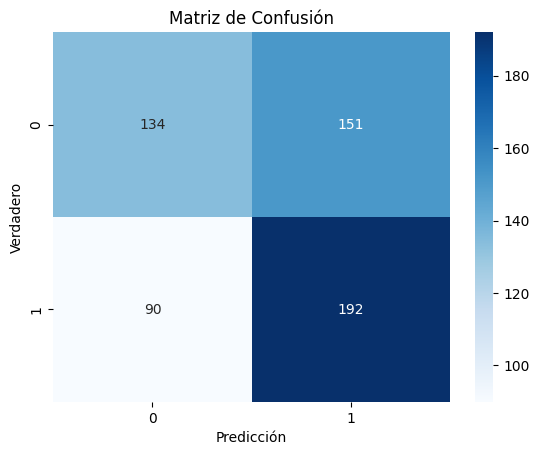

In [37]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.show()


Conclusiones del Modelo ExtraTreesClassifier
1️⃣ Mejoras logradas en la Clase 1

El recall de la clase 1 aumentó a 0.65, lo que significa que el modelo ahora está detectando más instancias de esta categoría en comparación con la versión anterior (~0.64).
Esto indica que los ajustes en class_weight, min_samples_leaf y criterion='entropy' han permitido una mejor clasificación de la clase 1.

2️⃣ Compromiso entre Precisión y Recall

La precisión de la clase 1 es 0.57, lo que indica que algunos de los ejemplos clasificados como 1 en realidad pertenecen a la clase 0.
Esto sugiere que el modelo aún tiene un margen de error en términos de falsos positivos.

3️⃣ Balance General del Modelo

La precisión global del modelo es 0.58, mostrando una ligera mejora con respecto al resultado anterior (~0.55).
El f1-score de la clase 1 es 0.61, lo que significa que hay una mejor relación entre precisión y recall en comparación con la clase 0 (0.55).